# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.2)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    def train_batch():
                        nonlocal train_loss
                        _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:1})
                    
                    train_batch()
                    count = 10
                    while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count < 1):
                        print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                        net.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()
                        count -= 1
                    
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                
                test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                  net.actual, net.y], #net.summary_op 
                                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                                 net.y_: preprocess.y_test, 
                                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}"
                          .format(epoch, train_loss, test_loss, test_accuracy))

                if test_accuracy > Train.best_acc_global:
                    Train.best_acc_global = test_accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    
                if test_accuracy > Train.best_acc:
                    Train.best_acc = test_accuracy
                    
                    if not (np.isnan(train_loss)):
                        net.saver.save(sess, 
                                   "dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}/model"
                                   .format(epochs,h,f), 
                                   global_step = epoch, 
                                   write_meta_graph=False)
                    
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):
                                              (curr_pred, 
                                               Train.result(epochs, f, h,valid_accuracy, test_accuracy, time.perf_counter() - start_time))})
                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [20]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:20 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000001 | Test Loss: 0.000228 | Test Accuracy: 0.779099
Step 2 | Training Loss: 0.000078 | Test Loss: 0.000192 | Test Accuracy: 0.801544
Step 3 | Training Loss: 0.000005 | Test Loss: 0.000283 | Test Accuracy: 0.795600
Step 4 | Training Loss: 0.000094 | Test Loss: 0.000254 | Test Accuracy: 0.795112
Step 5 | Training Loss: 0.000070 | Test Loss: 0.000167 | Test Accuracy: 0.810504
Step 6 | Training Loss: 0.000050 | Test Loss: 0.000249 | Test Accuracy: 0.785752
Step 7 | Training Loss: 0.000088 | Test Loss: 0.000243 | Test Accuracy: 0.804604
Step 8 | Training Loss: 0.000053 | Test Loss: 0.000157 | Test Accuracy: 0.792273
Step 9 | Training Loss: 0.000020 | Test Loss: 0.000287 | Test Accuracy: 0.739310
Step 10 | Training Loss: 0.000001 | Test Loss: 0.000256 | Test Accuracy: 0.738112
Step 11 | Training Loss: 0.000022 | Test Loss: 0.000222 | Test Accuracy: 0.770981
Step 12 | Training Loss: 0.000006 | T

Step 16 | Training Loss: 0.000021 | Test Loss: 0.000106 | Test Accuracy: 0.784555
Step 17 | Training Loss: 0.000004 | Test Loss: 0.000108 | Test Accuracy: 0.821061
Step 18 | Training Loss: 0.000032 | Test Loss: 0.000072 | Test Accuracy: 0.818355
Step 19 | Training Loss: 0.000036 | Test Loss: 0.000124 | Test Accuracy: 0.816448
Step 20 | Training Loss: 0.000009 | Test Loss: 0.000091 | Test Accuracy: 0.810415
Best Accuracy on Test data: 0.8579666614532471
Current Layer Attributes - epochs:20 hidden layers:4 features count:8
Step 1 | Training Loss: 0.000017 | Test Loss: 0.000369 | Test Accuracy: 0.718240
Step 2 | Training Loss: 0.000187 | Test Loss: 0.000338 | Test Accuracy: 0.668604
Step 3 | Training Loss: 0.000278 | Test Loss: 0.000564 | Test Accuracy: 0.659111
Step 4 | Training Loss: 0.136439 | Test Loss: 0.000335 | Test Accuracy: 0.633783
Step 5 | Training Loss: 0.000005 | Test Loss: 0.000100 | Test Accuracy: 0.675923
Step 6 | Training Loss: 0.000089 | Test Loss: 0.000379 | Test Accura

Step 11 | Training Loss: 0.000047 | Test Loss: 0.000243 | Test Accuracy: 0.801588
Step 12 | Training Loss: 0.000007 | Test Loss: 0.000303 | Test Accuracy: 0.802741
Step 13 | Training Loss: 0.000005 | Test Loss: 0.000253 | Test Accuracy: 0.848075
Step 14 | Training Loss: 0.000089 | Test Loss: 0.000228 | Test Accuracy: 0.835477
Step 15 | Training Loss: 0.000098 | Test Loss: 0.000138 | Test Accuracy: 0.863334
Step 16 | Training Loss: 0.000069 | Test Loss: 0.000220 | Test Accuracy: 0.828469
Step 17 | Training Loss: 0.000027 | Test Loss: 0.000222 | Test Accuracy: 0.821771
Step 18 | Training Loss: 0.000075 | Test Loss: 0.000232 | Test Accuracy: 0.864221
Step 19 | Training Loss: 0.000001 | Test Loss: 0.000175 | Test Accuracy: 0.854107
Step 20 | Training Loss: 0.000000 | Test Loss: 0.000173 | Test Accuracy: 0.853043
Best Accuracy on Test data: 0.8928318023681641
Current Layer Attributes - epochs:20 hidden layers:6 features count:16
Step 1 | Training Loss: 0.000009 | Test Loss: 0.000301 | Test 

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
9,20,8,6,0.896606,0.892832,18.282973
2,20,16,2,0.910498,0.884315,52.052245
8,20,4,6,0.900099,0.883960,79.896244
7,20,32,4,0.876999,0.877395,109.307383
11,20,32,6,0.872832,0.858321,56.983235
4,20,4,4,0.878309,0.857967,36.212009
1,20,8,2,0.831117,0.841466,46.666873
6,20,16,4,0.930304,0.836985,8.436142
10,20,16,6,0.882993,0.821327,9.489717
0,20,4,2,0.902123,0.810504,14.201883


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8587  0.1413]
 [ 0.0621  0.9379]]


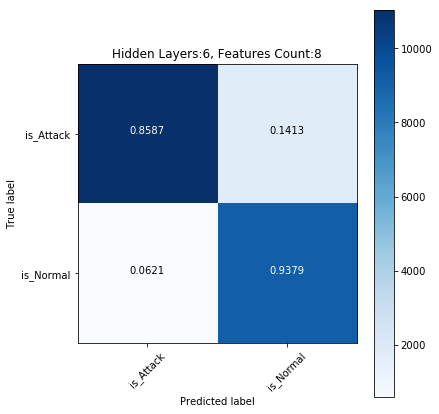

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)